In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from modules import optimize_null, forward_simulation, construct_null_trajectory
from modules.elbo import ELBO

### Load data

In [2]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches

subject = 'alexandra'
category = 'synthetic'
eccentricity = 'fovea'
movie_id = 6
dat_movie_name = 'DAM'   # movie name as in the data file name
stim_movie_name = 'carnegie-dam' # movie name as in the stimulus file name
n_bootstraps = 1

match eccentricity:
    case 'fovea':
        diameter = 6
    case 'parafovea':
        diameter = 24
    case _:
        diameter = 36

# dat = torch.load(Path('../data') / 'yoon_data' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
dat = torch.load(Path('../data') / 'behavioral_data_09052025' / 'pt' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
stim_folder = os.path.join('../data', 'yoon_stimulus', f'diameter_{diameter:02d}_deg', f'movie{movie_id:02d}-{stim_movie_name}')

In [3]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0


# ignore diagonals
np.fill_diagonal(n_corr_obs, 0)
np.fill_diagonal(n_total_obs, 0)

prop_corr_human = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Estimate most likely curvature on human data

In [4]:
n_dim = 10
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=40000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 411.18755496293306
Loss updated
Iteration 1 | Loss: 411.18755496293306
Current loss: 458.2961490750313
Iteration 2 | Loss: 458.2961490750313
Current loss: 429.7233891412616
Iteration 3 | Loss: 429.7233891412616
Current loss: 460.7844555824995
Iteration 4 | Loss: 460.7844555824995
Current loss: 424.1722106486559
Iteration 5 | Loss: 424.1722106486559
Current loss: 407.330376021564
Loss updated
Iteration 6 | Loss: 407.330376021564
Current loss: 445.50865326821804
Iteration 7 | Loss: 445.50865326821804
Current loss: 415.6309741958976
Iteration 8 | Loss: 415.6309741958976
Current loss: 423.2107305303216
Iteration 9 | Loss: 423.2107305303216
Current loss: 405.8796430006623
Loss updated
Iteration 10 | Loss: 405.8796430006623
Epoch: 0, Loss: 563.4142380327042
Epoch: 250, Loss: 554.4450779384177
Epoch: 500, Loss: 541.0242842933496
Epoch: 750, Loss: 538.7182480660116
Epoch: 1000, Loss: 532.7799962939994
Epoch: 1250, Loss

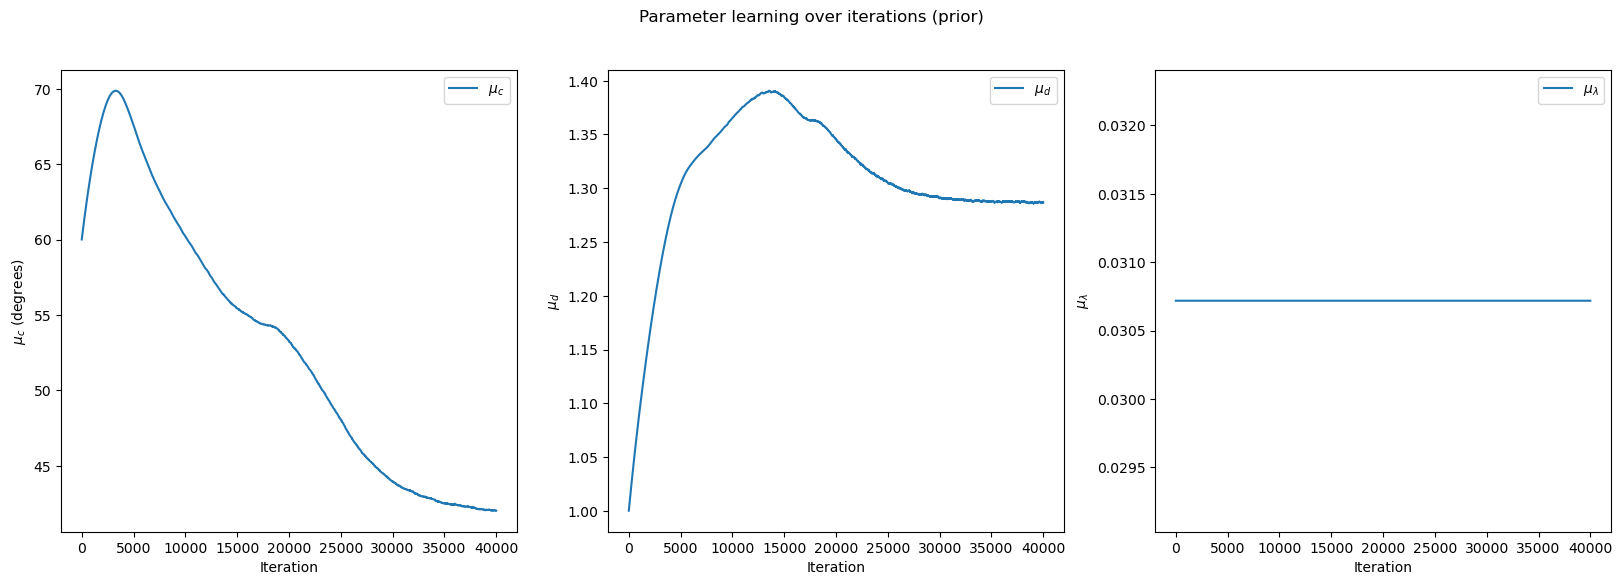

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

/var/folders/_c/tp58p8fd4t51w6w34tsknzpw0000gr/T/ipykernel_36365/2295650332.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  axs[2].plot(l_post.T)


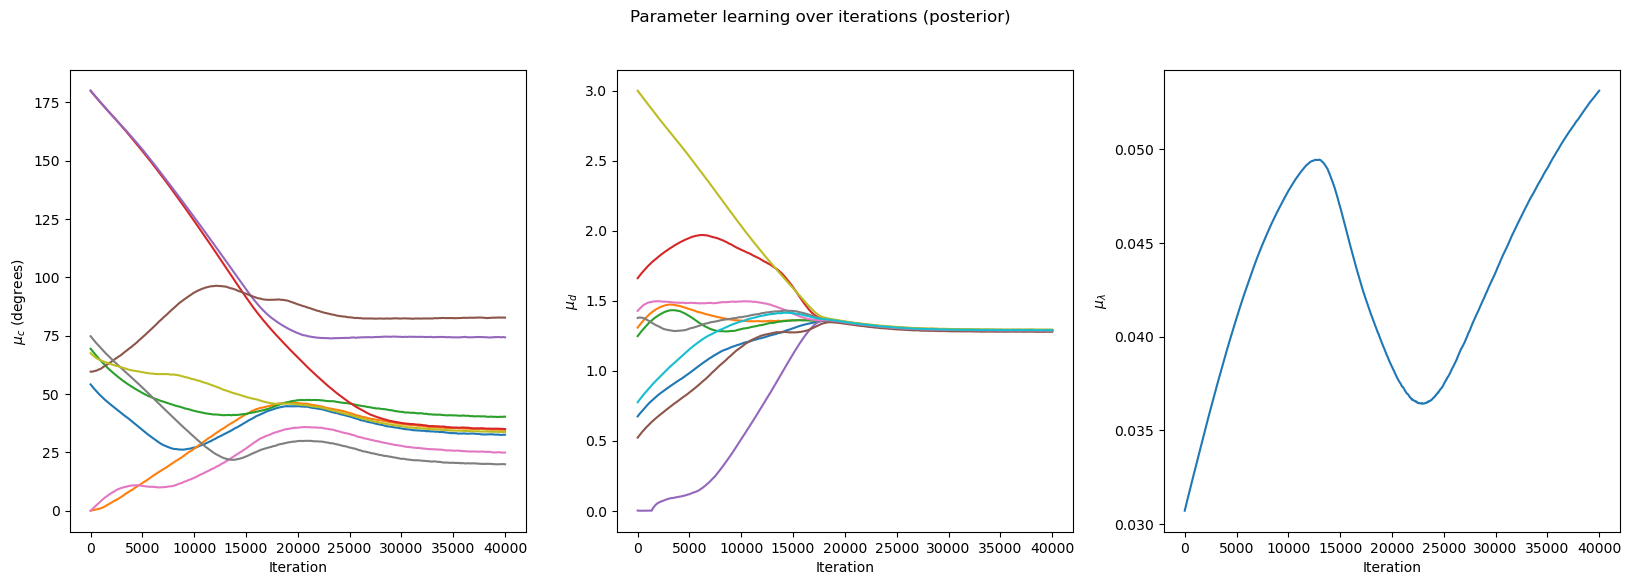

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [7]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 42.02377700805664 degrees
Average estimated local curvature: 42.02508624229449 degrees


In [8]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

In [9]:
def prepare_psychometric_plot(p):
    """
    Plot psychometric curve from a matrix where each entry corresponds to the proportion of correct responses for the AXB task. 

    Input:
    ------
    p: (n_frames x n_frames) Numpy array
        Estimated proportion correct from AXB task

    Outputs:
    -------
    unique_diffs: (n_frames - 1, ) Numpy array
        Array of unique frames differences
    mean_props: (n_frames - 1, ) Numpy array
        Average proportion of correct responses for each unique frame combination
    """

    n_frames = p.shape[0]

    # compute all possible frame differences and corresponding proportions
    diffs = []
    props = []

    for i in range(n_frames):
        for j in range(n_frames):
            if i != j:  # ignore diagonal (A == B)
                diffs.append(abs(i - j))
                props.append(p[i, j])

    diffs = np.array(diffs)
    props = np.array(props)

    # average proportion correct for each unique difference
    unique_diffs = np.unique(diffs)
    mean_props = np.array([np.nanmean(props[diffs == d]) for d in unique_diffs])

    return unique_diffs, mean_props

In [10]:
# aggregate proportion of correct responses for plotting psychometric function
unique_diffs_human, mean_props_human = prepare_psychometric_plot(prop_corr_human)
unique_diffs_est, mean_props_est = prepare_psychometric_plot(p.squeeze().detach().numpy())

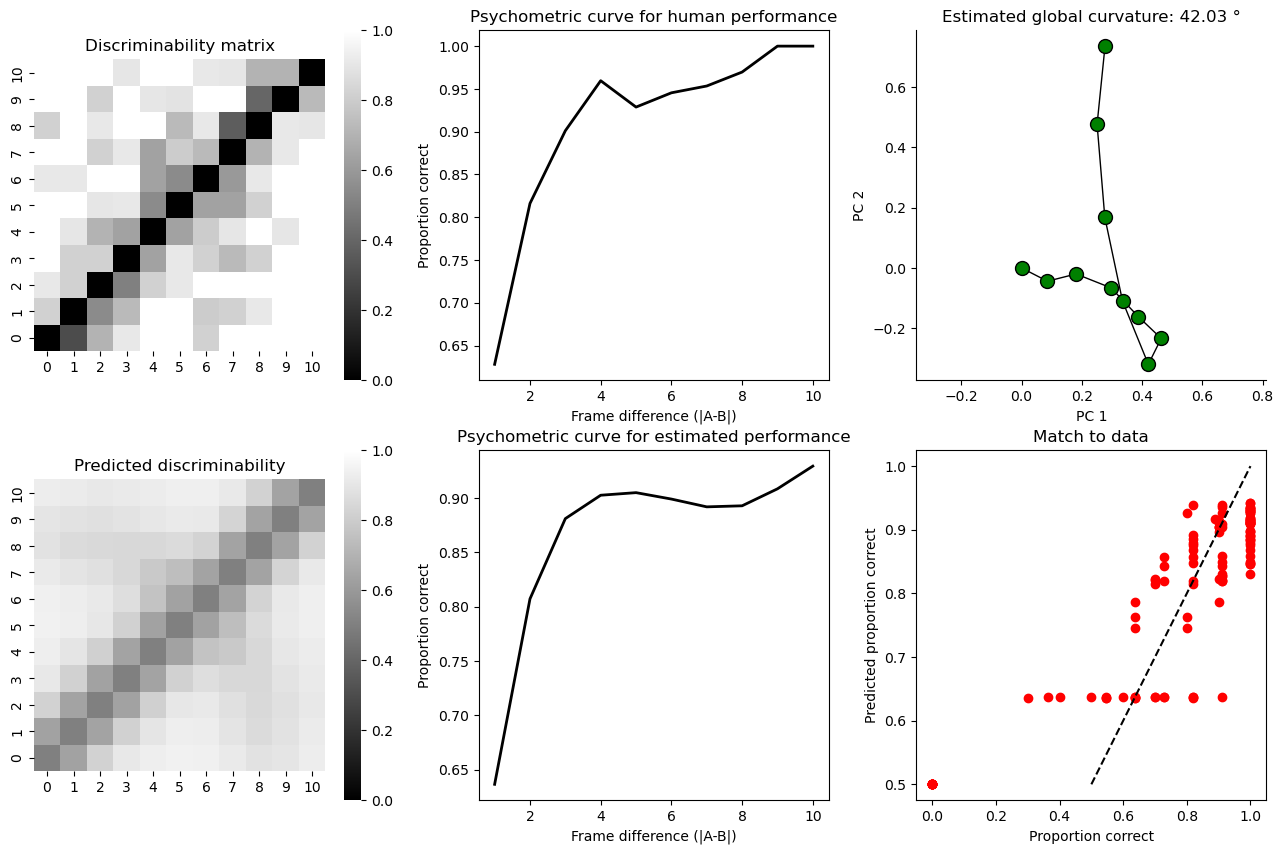

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

sns.heatmap(prop_corr_human, ax=axs[0, 0], vmin=0, vmax=1, cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(unique_diffs_human, mean_props_human, '-k', markersize=10, linewidth=2)
axs[0, 1].set_title('Psychometric curve for human performance')
axs[0, 1].set_xlabel('Frame difference (|A-B|)')
axs[0, 1].set_ylabel('Proportion correct')
axs[0, 1].set_box_aspect(1)

axs[0, 2].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 2].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 2].set_xlabel('PC 1')
axs[0, 2].set_ylabel('PC 2')
axs[0, 2].set_box_aspect(1)  
axs[0, 2].set_aspect('equal') 
axs[0, 2].spines['top'].set_visible(False)  
axs[0, 2].spines['right'].set_visible(False)
axs[0, 2].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], vmin=0, vmax=1, cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(unique_diffs_est, mean_props_est, '-k', markersize=10, linewidth=2)
axs[1, 1].set_title('Psychometric curve for estimated performance')
axs[1, 1].set_xlabel('Frame difference (|A-B|)')
axs[1, 1].set_ylabel('Proportion correct')
axs[1, 1].set_box_aspect(1)

axs[1, 2].plot(prop_corr_human.flatten(), p.flatten().detach(), 'ro')
axs[1, 2].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 2].set_title('Match to data')
axs[1, 2].set_xlabel('Proportion correct')
axs[1, 2].set_ylabel('Predicted proportion correct')
axs[1, 2].set_box_aspect(1)

plt.show()

In [12]:
print(f'Proportion of correct human responses: {np.mean(prop_corr_human)}')
print(f'Estimated proportion of correct responses {torch.mean(p.detach())}')

Proportion of correct human responses: 0.786384506219217
Estimated proportion of correct responses 0.8043615818023682


### Replace perceptual curvature with pixel-domain curvature 

In [13]:
is_natural = True if category == 'natural' else False
x_null, c_est_null, p_null = construct_null_trajectory(stim_folder, n_dim, elbo._transform(elbo.mu_post_d, 'd'), elbo.mu_post_a, is_natural, n_frames)
print(f'Pixel-domain curvature: {torch.mean(torch.rad2deg(c_est_null))}')

Pixel-domain curvature: 15.423481941223145


### Synthesize data from null model observer

In [14]:
# n_reps = int(np.max(n_total_obs))
n_reps = 10
prop_corr_null_sim, n_total_obs_null_sim = forward_simulation(x_null.detach().squeeze(), n_reps, var=1) 

unique_diffs_null, mean_props_null = prepare_psychometric_plot(prop_corr_null_sim)

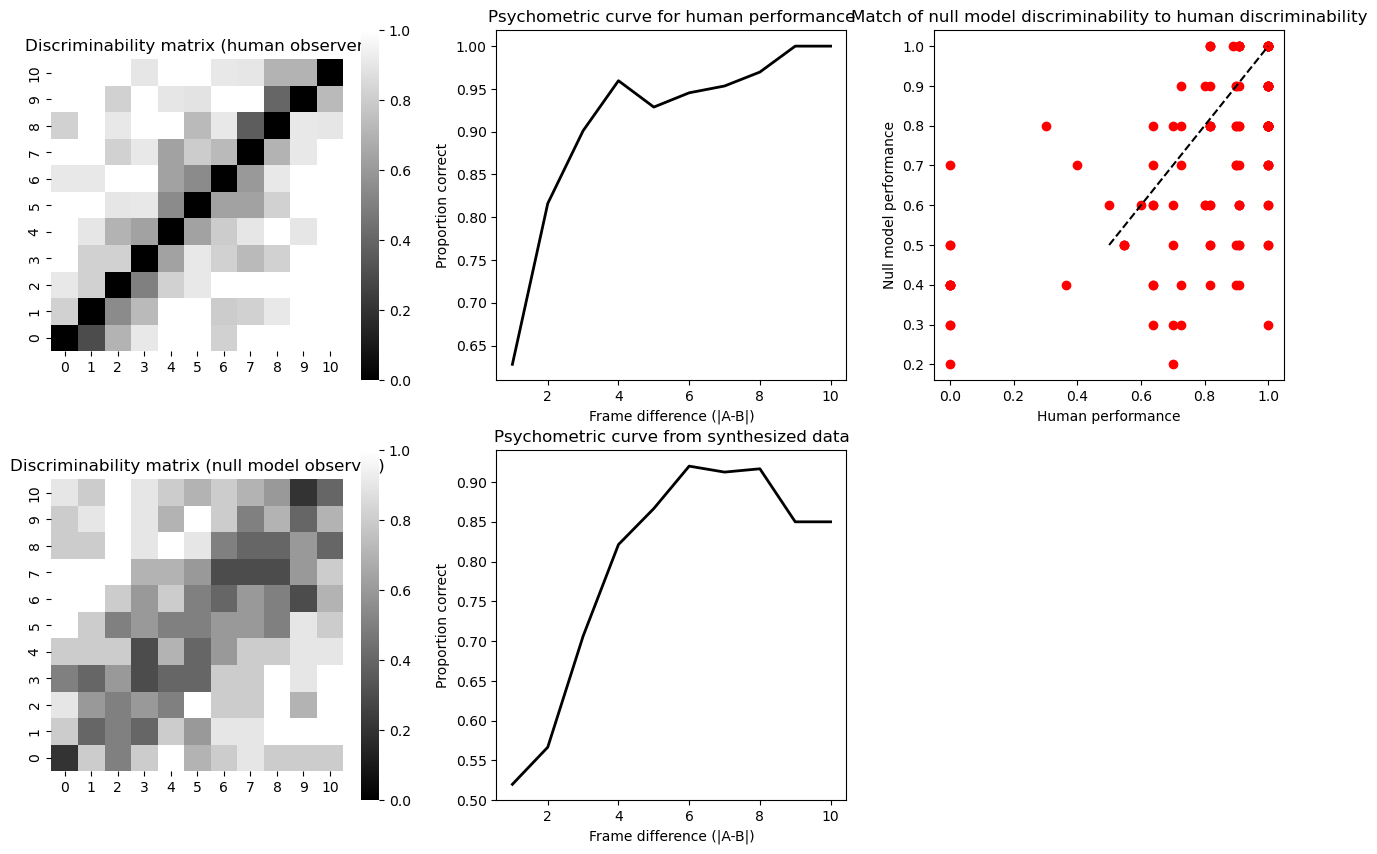

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

sns.heatmap(prop_corr_human, ax=axs[0, 0], vmin=0, vmax=1, cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix (human observer)')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(unique_diffs_human, mean_props_human, '-k', markersize=10, linewidth=2)
axs[0, 1].set_title('Psychometric curve for human performance')
axs[0, 1].set_xlabel('Frame difference (|A-B|)')
axs[0, 1].set_ylabel('Proportion correct')
axs[0, 1].set_box_aspect(1)

axs[0, 2].plot(prop_corr_human.flatten(), prop_corr_null_sim.flatten(), 'ro')
axs[0, 2].plot([0.5, 1], [0.5, 1], 'k--')
axs[0, 2].set_title('Match of null model discriminability to human discriminability')
axs[0, 2].set_xlabel('Human performance')
axs[0, 2].set_ylabel('Null model performance')
axs[0, 2].set_box_aspect(1)

sns.heatmap(prop_corr_null_sim, ax=axs[1, 0], vmin=0, vmax=1, cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Discriminability matrix (null model observer)')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(unique_diffs_null, mean_props_null, '-k', markersize=10, linewidth=2)
axs[1, 1].set_title('Psychometric curve from synthesized data')
axs[1, 1].set_xlabel('Frame difference (|A-B|)')
axs[1, 1].set_ylabel('Proportion correct')
axs[1, 1].set_box_aspect(1)

axs[1, 2].set_axis_off()

### Run optimization on simulated data from null model

In [16]:
# n_corr_obs_null = np.round(n_total_obs_null_sim * prob_corr_null_sim)
# prob_corr_null.fill_diagonal_(0.0)

n_corr_obs_null = np.round(n_total_obs_null_sim * prop_corr_null_sim) 

elbo_null = ELBO(n_dim, n_corr_obs_null, n_total_obs_null_sim, n_starts=10, n_iterations=40000)
x_null_elbo, p_null_elbo, errors_null_elbo, kl_loss_null, ll_loss_null, c_prior_null, d_prior_null, l_prior_null, c_post_null, d_post_null, l_post_null, c_est_null = elbo_null.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 426.426979765296
Loss updated
Iteration 1 | Loss: 426.426979765296
Current loss: 433.35477578639984
Iteration 2 | Loss: 433.35477578639984
Current loss: 437.26539830863476
Iteration 3 | Loss: 437.26539830863476
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 4 | Loss: 430.48977050185204
Current loss: 436.0169403925538
Iteration 5 | Loss: 436.0169403925538
Current loss: 439.19558364897966
Iteration 6 | Loss: 439.19558364897966
Current loss: 438.91779816895723
Iteration 7 | Loss: 438.91779816895723
Current loss: 433.03309769928455
Iteration 8 | Loss: 433.03309769928455
Current loss: 430.146505959332
Iteration 9 | Loss: 430.146505959332
Current loss: 430.75819635391235
Iteration 10 | Loss: 430.75819635391235
Epoch: 0, Loss: 3424.677228495859
Epoch: 250, Loss: 1856.454716700912
Epoch: 500, Loss: 1412.0140807462103
Epoch: 750, Loss: 1194.6255368270133
Epoch: 1000, Loss: 1055.0749991132043
Epoch: 1250, Loss: 960.89748646276

In [17]:
n_corr_obs_null = (p_null.squeeze().detach().numpy() * n_total_obs)

# ignore diagonals
np.fill_diagonal(n_corr_obs_null, 0)
# np.fill_diagonal(n_total_obs, 0)

elbo_null = ELBO(n_dim, n_corr_obs_null, n_total_obs, n_starts=10, n_iterations=40000)
x_null_elbo, p_null_elbo, errors_null_elbo, kl_loss_null, ll_loss_null, c_prior_null, d_prior_null, l_prior_null, c_post_null, d_post_null, l_post_null, c_est_null = elbo_null.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 421.4140286566635
Loss updated
Iteration 1 | Loss: 421.4140286566635
Current loss: 432.1335757502857
Iteration 2 | Loss: 432.1335757502857
Current loss: 421.52198706484484
Iteration 3 | Loss: 421.52198706484484
Current loss: 451.38062725260323
Iteration 4 | Loss: 451.38062725260323
Current loss: 424.7544613189787
Iteration 5 | Loss: 424.7544613189787
Current loss: 459.98535507254087
Iteration 6 | Loss: 459.98535507254087
Current loss: 442.80428946835127
Iteration 7 | Loss: 442.80428946835127
Current loss: 445.2081773534236
Iteration 8 | Loss: 445.2081773534236
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 9 | Loss: 426.3896709977792
Current loss: 437.00542919607005
Iteration 10 | Loss: 437.00542919607005
Epoch: 0, Loss: 1067.3678824603344
Epoch: 250, Loss: 894.8221028736292
Epoch: 500, Loss: 808.3535889781574
Epoch: 750, Loss: 741.8988385746234
Epoch: 1000, Loss: 703.8085379050522
Epoch: 1250, Loss: 664.414791838466

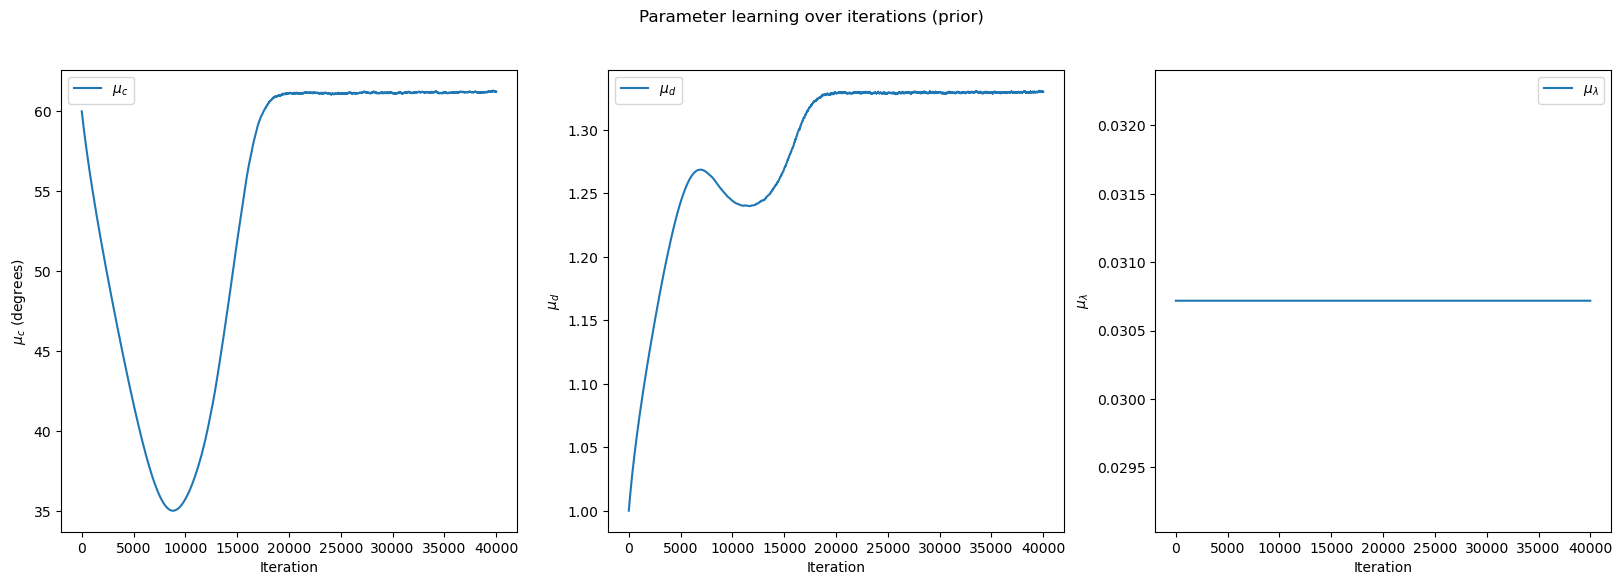

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior_null, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior_null, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior_null, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

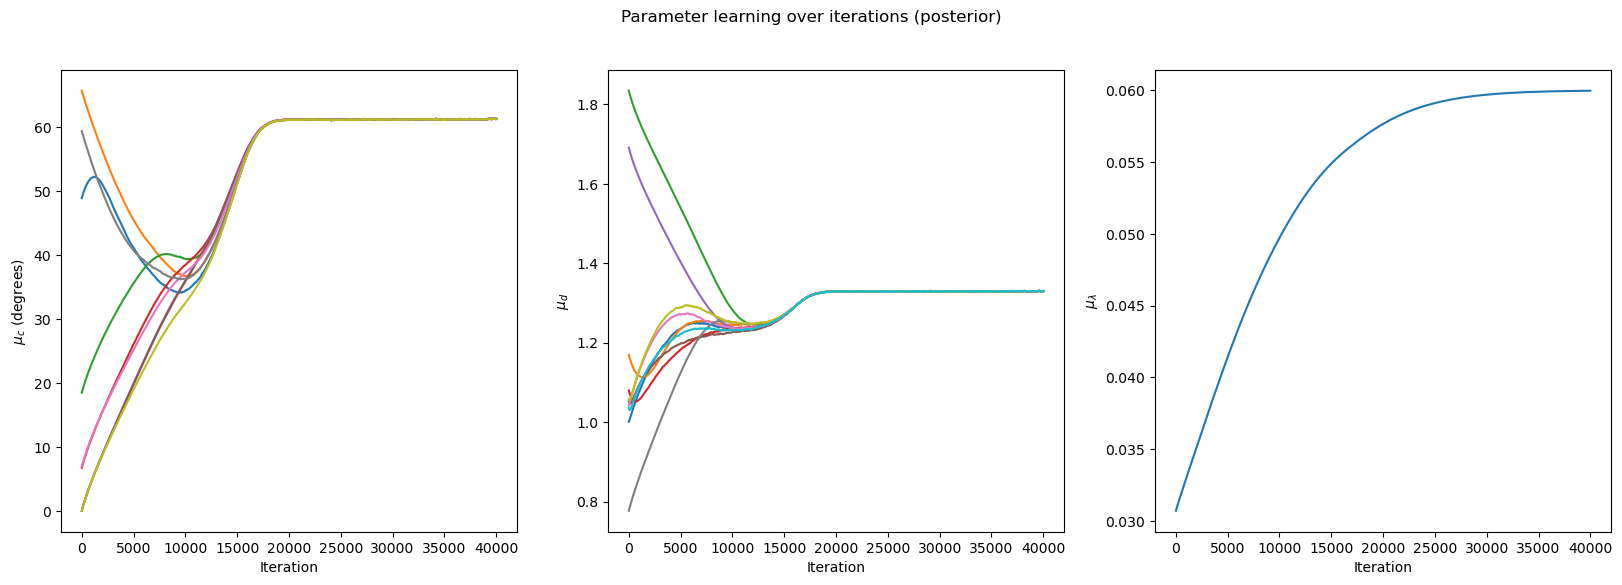

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post_null.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post_null.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post_null.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [20]:
est_global_curvature_null = torch.rad2deg(elbo_null.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature_null} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo_null.mu_post_c).detach())} degrees')

Estimated global curvature: 61.2371826171875 degrees
Average estimated local curvature: 61.23990740375883 degrees


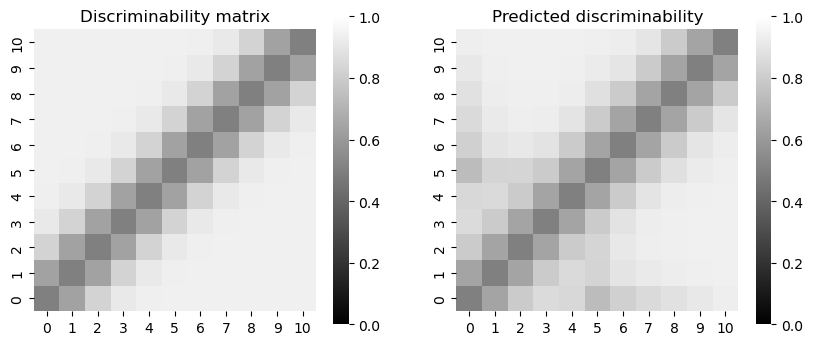

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

sns.heatmap(p_null.squeeze().detach().numpy(), ax=axs[0], vmin=0, vmax=1, cmap='gray', cbar_kws={"shrink": 0.4})
axs[0].invert_yaxis()
axs[0].set_title('Discriminability matrix')
axs[0].set_box_aspect(1)

sns.heatmap(p_null_elbo.detach().squeeze(), ax=axs[1], vmin=0, vmax=1, cmap='gray', cbar_kws={"shrink": 0.4})
axs[1].invert_yaxis()
axs[1].set_title('Predicted discriminability')
axs[1].set_box_aspect(1)
plt.show()